In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as ppf #EDA report 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder,RobustScaler,StandardScaler
from sklearn.metrics import accuracy_score


from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import Pipeline, make_pipeline#构建管道
from scipy.stats import skew#偏度
from sklearn.preprocessing import Imputer

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

### EDA with One-click 
Here use `pandas_profiling` to do Exploratory data analysis; this powerful packckage will generate a very detailed report of the dataset with missing values, variables analysis, all kinds of basic plot and corellation analysis, and hence we could have a overview about the dataset we're starring at.

In [49]:
"""profile = ppf.ProfileReport(train) #EDA 
profile.to_file(output_file="eda-report.html")"""
ppf.ProfileReport(train)

Now let's have some tastes about our dataset with some plots. 
boxplot and scatter plot are used to find out the outliers.

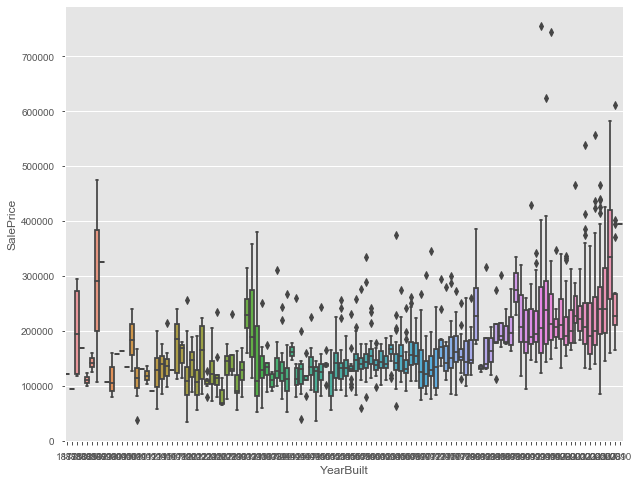

In [3]:
plt.figure(figsize=(10,8))
sns.boxplot(train.YearBuilt, train.SalePrice)

(0, 800000)

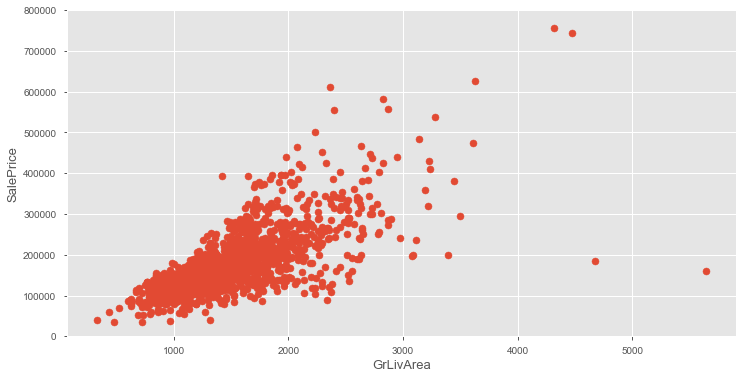

In [4]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea,y = train.SalePrice) ## scatter plot used to check if there any linear relationships
plt.xlabel('GrLivArea',fontsize = 13)
plt.ylabel('SalePrice',fontsize = 13)
plt.ylim(0,800000)

In [3]:
# delete the outliers' index
train.drop(train[(train.GrLivArea>4000) & (train.SalePrice<300000)].index,inplace = True)

In [4]:
# concat the train and test for later use for data cleaning.
full = pd.concat([train,test],ignore_index=True)
# Delete the repeated 'Id' column
full.drop('Id',axis = 1,inplace = True)


### Data Cleaning

1. fill missing values;
2. remove missing values;


In [5]:
# count the missing values with
miss = full.isnull().sum()
# sort the counts with descending order when counts not equal to zero
miss[miss>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

#### fill and remove the missing values
1. for string type of values, fillna with `None`
2. for numerical values, 

In [6]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 80 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            198 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2835 non-null object
BsmtExposure     2835 non-null object
BsmtFinSF1       2916 non-null float64
BsmtFinSF2       2916 non-null float64
BsmtFinType1     2838 non-null object
BsmtFinType2     2837 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2836 non-null object
BsmtUnfSF        2916 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2916 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      291

Select all the columns that contains string value, and fillna with 'None'

In [7]:
colstr = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in colstr:
    full[col].fillna("None",inplace=True)

Select some of the columns that contains numerical value, and fillna with 0

In [8]:
colnu=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in colnu:
    full[col].fillna(0, inplace=True)

`LotFrontage` has only 486 vlaues, which means it has a lot missing values, so replace the missing values with the mean() of this column.

In [9]:
full.LotFrontage.fillna(np.mean(full.LotFrontage),inplace = True)

For the following colmns, fillna with mode()

In [10]:
cols = ["MSZoning", "BsmtFullBath", 'GarageYrBlt',"BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols:
    full[col].fillna(full[col].mode()[0], inplace=True)

Check is there are any col with missing values. Supposedly in the `full`, there is a column `SalePrice` still has a lot of missing values, since we have concat the `train` and `test`, and `test` set has `SalePrice` left blank, for it is the value we need to predict as our ultimate goal in the project.

In [72]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

### Data Preprocessing - Feature Engineering

Transform the catagorical data to numerical data. Complete this by `LabelEncoder` and `get_dummies`

In [11]:
for col in cols:
    full[col]=full[col].astype(str)
full["GarageYrBlt"] = full["GarageYrBlt"].astype(str)

In [12]:
lab = LabelEncoder()
for item in colstr:
    full[item] = lab.fit_transform(full[item])
for item in cols:
    full[item] = lab.fit_transform(full[item])

In [ ]:
import seaborn as sns
corrmat = full.corr() 
cols = corrmat.nlargest(30).index 
  
cm = np.corrcoef(full[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 
#plt.savefig("fig/corellation2.png")

In [13]:
full.drop("SalePrice",axis=1,inplace=True)

## pipeline

In [17]:
# define a label encoding class
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        X["BldgType"] = lab.fit_transform(X["BldgType"])
        X['OverallQual'] = lab.fit_transform(X['OverallQual'])
        X['GrLivArea'] = lab.fit_transform(X['GrLivArea'])
        X['GarageArea'] = lab.fit_transform(X['GarageArea'])
        X['FullBath'] = lab.fit_transform(X['FullBath'])
        X['OpenPorchSF'] = lab.fit_transform(X['OpenPorchSF'])
        X['GarageCars'] = lab.fit_transform(X['GarageCars'])
        return X

In [18]:
# make a transform class
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):#偏度
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])#而是去除了包含了对象数据类型，取出来绝大部分是数值型
        skewness = X_numeric.apply(lambda x: skew(x))#匿名函数，做成字典的形式
        skewness_features = skewness[abs(skewness) >= self.skew].index#通过条件来涮选出skew>=0.5的索引的条件，取到了全部数据，防止数据的丢失
        X[skewness_features] = np.log1p(X[skewness_features])#求对数，进一步让他更符合正态分布
        X = pd.get_dummies(X)##一键独热，独热编码，（试错经历）
        return X

In [19]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=3)),
    ])

In [20]:
# 保存原来的数据以备后用，为了防止写错
full2 = full.copy()

pipeline_data = pipe.fit_transform(full2)

In [21]:
pipeline_data.shape

(2917, 178)

In [22]:
n_train=train.shape[0]#训练集的行数
X = pipeline_data[:n_train]#取出处理之后的训练集
test_X = pipeline_data[n_train:]#取出n_train后的数据作为测试集
y= train.SalePrice
X_scaled = StandardScaler().fit(X).transform(X)#做转换
y_log = np.log(train.SalePrice)##这里要注意的是，更符合正态分布
#得到测试集
test_X_scaled = StandardScaler().fit_transform(test_X)

## feature selection

In [23]:
from sklearn.linear_model import Lasso##运用算法来进行训练集的得到特征的重要性，特征选择的一个作用是，wrapper基础模型; lasso => lr+l1 norm
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=pipeline_data.columns)#索引和重要性做成dataframe形式
FI_lasso.sort_values("Feature Importance",ascending=False)

Feature Importance
2ndFlrSF                         0.073751
OverallQual                      0.070739
1stFlrSF                         0.068060
YearBuilt                        0.054120
TotalBsmtSF                      0.045536
OverallCond                      0.045475
LotArea                          0.043450
GrLivArea                        0.031390
GarageCars                       0.022265
BsmtFinSF1                       0.021998
Neighborhood_Crawfor             0.021055
Neighborhood_Somerst             0.019246
Functional                       0.016239
Neighborhood_StoneBr             0.014393
Neighborhood_NridgHt             0.013836
Condition1_Norm                  0.012847
MSZoning                         0.012550
Foundation_PConc                 0.012429
BsmtFullBath                     0.012323
Fireplaces                       0.012047
YearRemodAdd                     0.011888
SaleCondition_Partial            0.011423
GarageArea                       0.011088
HeatingQC_Ex                     0.010775
ScreenPorch                      0.010752
WoodDeckSF                       0.009252
FullBath                         0.008819
TotRmsAbvGrd                     0.008356
HalfBath                         0.007744
OpenPorchSF                      0.006923
...                                   ...
MiscVal                         -0.003072
Utilities                       -0.003239
BsmtExposure                    -0.003329
Condition2_RRAe                 -0.003340
Condition1_Artery               -0.003644
YrSold                          -0.003967
Neighborhood_BrDale             -0.004012
RoofMatl_Tar&Grv                -0.004018
HeatingQC_TA                    -0.004831
LotConfig_FR2                   -0.005249
Foundation_Wood                 -0.005455
Neighborhood_NWAmes             -0.005556
BsmtFinType1                    -0.005618
PavedDrive_N                    -0.005953
SaleCondition_Family            -0.006480
Exterior1st                     -0.006699
Neighborhood_Mitchel            -0.007068
Street_Grvl                     -0.007161
Condition1_RRAe                 -0.007650
BsmtQual                        -0.008335
BsmtUnfSF                       -0.008657
Neighborhood_Edwards            -0.009137
Heating_Grav                    -0.010206
KitchenQual                     -0.012203
Neighborhood_OldTown            -0.012961
Neighborhood_MeadowV            -0.013655
KitchenAbvGr                    -0.013816
Neighborhood_IDOTRR             -0.014375
CentralAir_N                    -0.016894
SaleCondition_Abnorml           -0.019192

[178 rows x 1 columns]

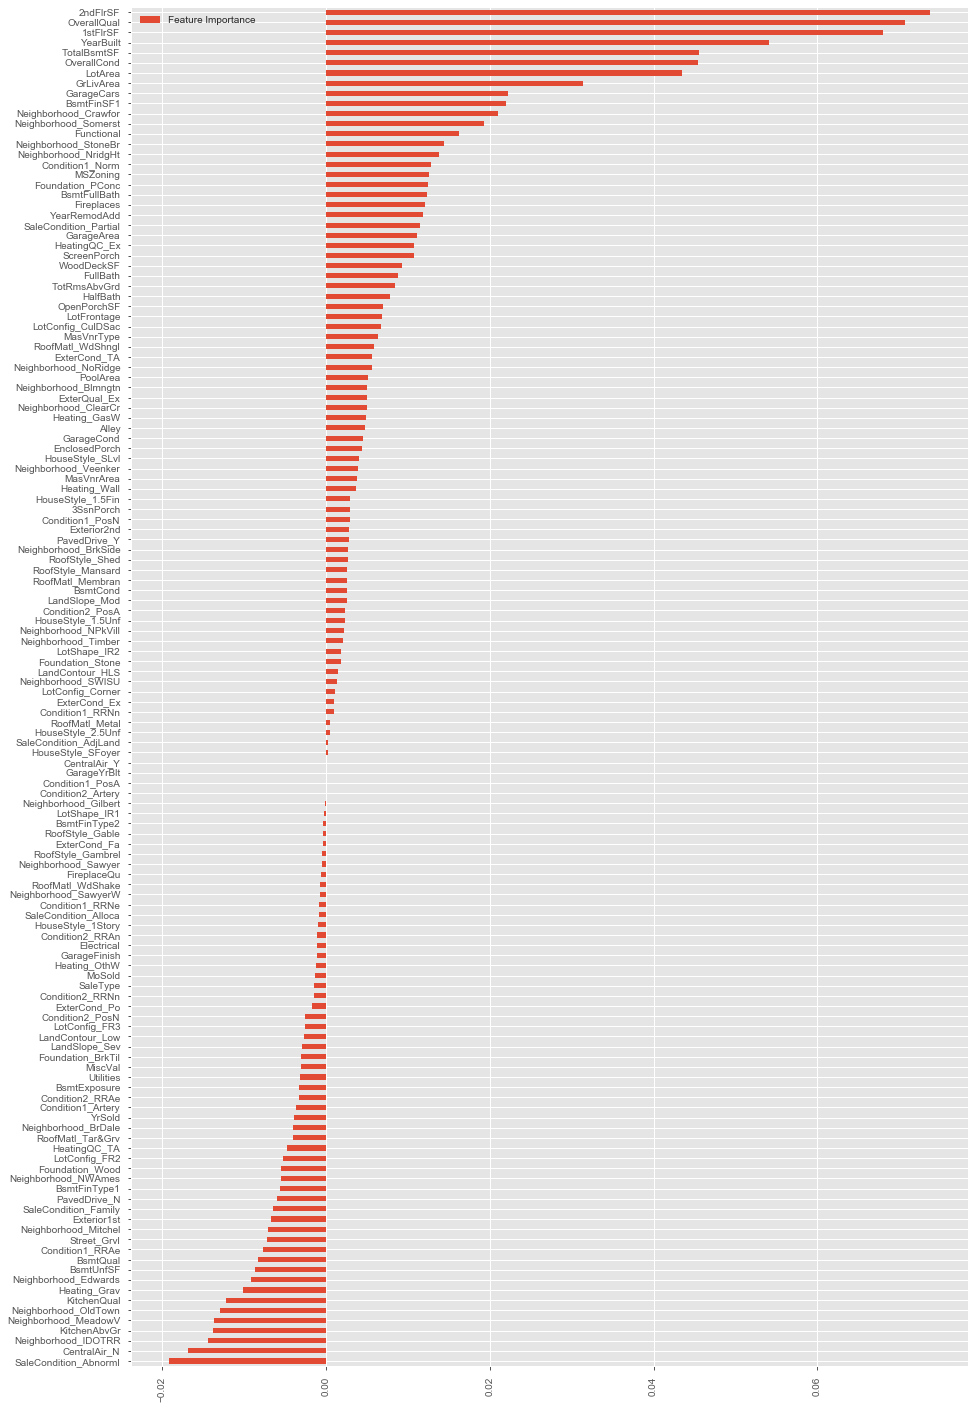

In [25]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

### feature crossing

In [26]:
##大家的发挥空间比较大，可以随意的定制，自己做两种特征
class add_feature(BaseEstimator, TransformerMixin):#自己定义转换函数--fit_transform由自己定义
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["MSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["MSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["MSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["Neighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["Neighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["Neighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["Functional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["Functional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["Condition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["Condition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [27]:
pipe = Pipeline([#把后面的东西加到管道里面来
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=1)),
    ('skew_dummies', skew_dummies(skew=4)),
    ])

In [29]:
#pipeline_data = pipe.fit_transform(full2)

In [30]:
n_train=train.shape[0]#训练集的行数
X = pipeline_data[:n_train]#取出处理之后的训练集
test_X = pipeline_data[n_train:]#取出n_train后的数据作为测试集
y= train.SalePrice
X_scaled = StandardScaler().fit(X).transform(X)#做转换
y_log = np.log(train.SalePrice)##这里要注意的是，更符合正态分布
#得到测试集
test_X_scaled = StandardScaler().fit_transform(test_X)

## Ensemble Learning 

In [34]:
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [38]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [36]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),
          BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [39]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 1259730837702.973145, 1053868002067.9891
Ridge: 0.119351, 0.0072
Lasso: 0.122404, 0.0066
RF: 0.146312, 0.0065
GBR: 0.123207, 0.0075
SVR: 0.180208, 0.0131
LinSVR: 1.245366, 0.4947
Ela: 0.116797, 0.0066
SGD: 2.920401, 0.9214
Bay: 0.117995, 0.0062
Ker: 0.114570, 0.0076
Extra: 0.138775, 0.0097
[23:37:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:10] WARNING: C:/Jenkins/workspace/xgboost-

In [40]:
##定义交叉方式，先指定模型后指定参数，方便测试多个模型，网格交叉验证
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [41]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})

{'alpha': 0.0009, 'max_iter': 10000} 0.11608834671715162
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.117308        0.001564
1  {'alpha': 0.0005, 'max_iter': 10000}         0.117005        0.001545
2  {'alpha': 0.0007, 'max_iter': 10000}         0.116502        0.001503
3  {'alpha': 0.0006, 'max_iter': 10000}         0.116746        0.001527
4  {'alpha': 0.0009, 'max_iter': 10000}         0.116088        0.001449
5  {'alpha': 0.0008, 'max_iter': 10000}         0.116295        0.001475


In [42]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'alpha': 90} 0.1180101666327102
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.118395        0.001496
1  {'alpha': 40}         0.118324        0.001486
2  {'alpha': 45}         0.118263        0.001478
3  {'alpha': 50}         0.118211        0.001471
4  {'alpha': 55}         0.118167        0.001465
5  {'alpha': 60}         0.118130        0.001460
6  {'alpha': 65}         0.118098        0.001455
7  {'alpha': 70}         0.118072        0.001452
8  {'alpha': 80}         0.118033        0.001446
9  {'alpha': 90}         0.118010        0.001441
{'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, 'kernel': 'rbf'} 0.11704304052006036
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.117158   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.118310   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.117171   
3   {'C': 11, 'epsilon': 0.009, 'gamma'

In [43]:
param_grid={'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}#定义好的参数，用字典来表示
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.5, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'} 0.12618147507044333
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.146091   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.133459   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...         0.128147   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.146674   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.132909   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...         0.127093   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.147561   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.132771   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...         0.126511   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...         0.148599   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...         0.132850   
11  {'alpha': 0.5, 'coef0'

In [44]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

{'alpha': 0.004, 'l1_ratio': 0.7, 'max_iter': 10000} 0.11459789448545993
                                               params  mean_test_score  \
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...         0.119333   
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...         0.119255   
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...         0.118589   
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter':...         0.118032   
4   {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter':...         0.117526   
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.119129   
6   {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.119016   
7   {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.118056   
8   {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter':...         0.117293   
9   {'alpha': 0.0008, 'l1_ratio': 0.7, 'max_iter':...         0.116844   
10  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.117536   
11  {'alpha': 0.004, 'l1_ratio': 0.1, '

In [45]:
##定义加权平均值，就相当于自己写fit_transform（）
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod##模型的个数
        self.weight = weight##权重
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # 针对于每一个数据点，单一的模型是乘以权重，然后加起来
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [46]:
#指定每一个算法的参数
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [47]:
##6个权重
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

In [48]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])
rmse_cv(weight_avg,X_scaled,y_log),  rmse_cv(weight_avg,X_scaled,y_log).mean()##计算出交叉验证的均值
# 这是第一层模型的个数

(array([0.11827175, 0.12730968, 0.12246549, 0.10342715, 0.11282417]),
 0.11685964856925937)

### Stacking

In [49]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model#元模型
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)##这就是堆叠的最大特征进行了几折的划分
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod] # use models to fit 
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):#返回的是索引和模型本身
            for train_index, val_index in self.kf.split(X,y):##返回的是数据本省
                renew_model = clone(model)##模型的复制
                renew_model.fit(X[train_index], y[train_index])#对数据进行训练
                self.saved_model[i].append(renew_model)##把模型添加进去
                oof_train[val_index,i] = renew_model.predict(X[val_index])##用来预测验证集
        
        self.meta_model.fit(oof_train,y)#元模型
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) ##得到的是整个测试集
        return self.meta_model.predict(whole_test)#返回的是利用元模型来对整个测试集进行预测
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))##初始化为0
        test_single = np.zeros((test_X.shape[0],5))##初始化为0 
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):##i是模型
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):##j是所有划分好的的数据
                clone_model = clone(model)##克隆模块，相当于把模型复制一下
                clone_model.fit(X[train_index],y[train_index])##把分割好的数据进行训练
                oof[val_index,i] = clone_model.predict(X[val_index])##对验证集进行预测
                test_single[:,j] = clone_model.predict(test_X)##对测试集进行预测
            test_mean[:,i] = test_single.mean(axis=1)##测试集算好均值
        return oof, test_mean

In [50]:
##经过预处理之后才能放到堆叠的模型里面去计算
a = Imputer().fit_transform(X_scaled)#相当于x
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()#相当于y

In [51]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)#定义了第一层的和第二层的模型

In [52]:
print(rmse_cv(stack_model,a,b))##运用了评估函数
print(rmse_cv(stack_model,a,b).mean())

[0.10934447 0.12123365 0.12360354 0.10377471 0.11082504]
0.1137562814430638


In [54]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scaled)#将数据进行变换
X_train_stack.shape, a.shape

((1458, 6), (1458, 178))

In [55]:
X_train_add = np.hstack((a,X_train_stack))
X_test_add = np.hstack((test_X_scaled,X_test_stack))
X_train_add.shape, X_test_add.shape

((1458, 184), (1459, 184))

In [56]:
print(rmse_cv(stack_model,X_train_add,b))
print(rmse_cv(stack_model,X_train_add,b).mean())

[0.09781168 0.1040782  0.10919774 0.09182738 0.10051549]
0.10068609919621523


In [57]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)
stack_model.fit(a,b)#模型进行训练

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [58]:
predicted = np.exp(stack_model.predict(test_X_scaled))##np.exp是对上面的对数变换之后的反变换

In [59]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':predicted})
result.to_csv("submission/submission_v3.csv",index=False)